In [2]:
import numpy as np
from torch import Tensor
from MLCode.utils import load_cup_data, np_cup_TR, plot_NN_TR_VAL
from sklearn.preprocessing import StandardScaler
from MLCode.NN import NN_HyperParameters
from MLCode.NN_cup import NN_Regressor, train_NN_cup, save_training, train_NN_K_validation, saved_NN_models


import matplotlib.pyplot as plt

df = load_cup_data()
X, Y = np_cup_TR(df)
Y_scaler = StandardScaler()
Y_scaler.fit(Y)
X, Y = Tensor(X), Tensor(Y)

# 10% test set
test_samples = X.shape[0] // 10

X_dev = X[:-test_samples]
Y_dev = Y[:-test_samples]

X_test = X[-test_samples:]
Y_test = Y[-test_samples:]

# 20% validation
val_samples = X_dev.shape[0] // 5
X_train = X_dev[:-val_samples]
Y_train = Y_dev[:-val_samples]

X_val = X_dev[-val_samples:]
Y_val = Y_dev[-val_samples:]



In [171]:
NN_HP = NN_HyperParameters(
    [10, 25, 25],
    lr=10E-4,
    beta1=0.9,
    beta2=0.999,
    weight_decay=0,
    mb_size=32,
)
net = NN_Regressor(2,NN_HP, Y_scaler)


# stats = train_NN_cup(net, X_train, Y_train, X_val, Y_val, 20,500)
stats = train_NN_K_validation(net, 5, X_dev, Y_dev, 3)
# print(stats)
save_training(stats, NN_HP)

layers = [ 10, 25, 25,]
lr = 0.001
beta1 = 0.9
beta2 = 0.999
weight_decay = 0
mb_size = 32

MEE mean: 3.0135593931876934
MEE std: 0.1816002198670425
Time (seconds): 13.291365253999174
Convergence: True


In [205]:
df = saved_NN_models()
df = df.sort_values(by=['MEE_mean'])
# select on number of layers:
df = df[df['model_name'].str.startswith('2')]
df




,model_name,MEE_mean,MEE_std
6,2x50_1.0E-03,2.961157,0.128865
25,2x100_1.0E-03,2.993633,0.154555
30,2x250_5.0E-04,3.009175,0.132695
32,2x25_1.0E-03,3.013559,0.181600
22,2x1500_1.0E-03,3.015799,0.171881
7,2x1000_1.0E-03,3.016355,0.130046
31,2x80_1.0E-03,3.016712,0.163406
33,2x500_1.0E-04,3.024054,0.139411
0,2x500_5.0E-04,3.031312,0.097888
37,2x1000_5.0E-04,3.033739,0.123024


In [197]:
import pandas as pd
import seaborn as sns

df = saved_NN_models()
df = df.sort_values(by=['model_name'])
# select on number of layers:
df = df[df['model_name'].str.startswith('2')]

array = df['model_name'].to_numpy()
array = array.reshape(-1,3).transpose()
df2 = pd.DataFrame(array)
df2 = df2.reindex([0,2,1])
df2 = df2[[4,6,7,1,3,5,0,2]]
df2

,4,6,7,1,3,5,0,2
0,2x25_1.0E-03,2x50_1.0E-03,2x80_1.0E-03,2x100_1.0E-03,2x250_1.0E-03,2x500_1.0E-03,2x1000_1.0E-03,2x1500_1.0E-03
2,2x25_5.0E-04,2x50_5.0E-04,2x80_5.0E-04,2x100_5.0E-04,2x250_5.0E-04,2x500_5.0E-04,2x1000_5.0E-04,2x1500_5.0E-04
1,2x25_1.0E-04,2x50_1.0E-04,2x80_1.0E-04,2x100_1.0E-04,2x250_1.0E-04,2x500_1.0E-04,2x1000_1.0E-04,2x1500_1.0E-04


In [195]:
array = df['MEE_mean'].to_numpy()
array = array.reshape(-1,3).transpose()
df2 = pd.DataFrame(array)
df2 = df2.reindex([0,2,1])
df2 = df2[[4,6,7,1,3,5,0,2]]
df2
# sns.heatmap(df2.to_numpy(), cmap='Greys_r')

,4,6,7,1,3,5,0,2
0,3.013559,2.961157,3.016712,2.993633,3.056422,3.051055,3.016355,3.015799
2,3.057410,3.081830,3.040024,3.035226,3.009175,3.031312,3.033739,3.051006
1,3.266189,3.247102,3.096421,3.140111,3.060529,3.024054,3.044043,3.050715


<AxesSubplot:>

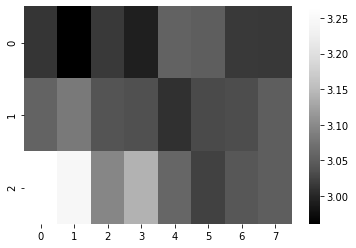

In [196]:
sns.heatmap(df2.to_numpy(), cmap='Greys_r')

In [204]:
import pandas as pd
import seaborn as sns

df = saved_NN_models()
df = df.sort_values(by=['model_name'])
# select on number of layers:
df = df[df['model_name'].str.startswith('3')]

array = df['model_name'].to_numpy()
array = array.reshape(-1,3).transpose()
df2 = pd.DataFrame(array)
df2 = df2.reindex([0,2,1])
df2 = df2[[3,4,1,2,0]]
df2

,3,4,1,2,0
0,3x50_1.0E-03,3x80_1.0E-03,3x100_1.0E-03,3x500_1.0E-03,3x1000_1.0E-03
2,3x50_5.0E-04,3x80_5.0E-04,3x100_5.0E-04,3x500_5.0E-04,3x1000_5.0E-04
1,3x50_1.0E-04,3x80_1.0E-04,3x100_1.0E-04,3x500_1.0E-04,3x1000_1.0E-04


In [201]:
array = df['MEE_mean'].to_numpy()
array = array.reshape(-1,3).transpose()
df2 = pd.DataFrame(array)
df2 = df2.reindex([0,2,1])
df2 = df2[[3,4,1,2,0]]
df2
# sns.heatmap(df2.to_numpy(), cmap='Greys_r')

,3,4,1,2,0
0,2.955938,3.001191,3.024914,3.011367,3.031735
2,2.964084,2.987514,2.984434,3.054194,3.148717
1,3.046989,3.097001,3.100388,3.076117,3.125940


<AxesSubplot:>

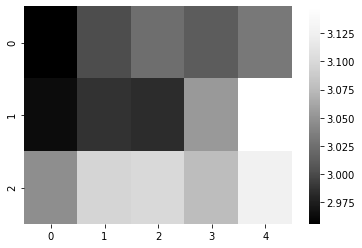

In [202]:
sns.heatmap(df2.to_numpy(), cmap='Greys_r')